In [461]:
# Install necessary packages
%pip install openmeteo-requests
%pip install requests-cache retry-requests numpy pandas


Note: you may need to restart the kernel to use updated packages.



In [462]:
# Import dependencies
import openmeteo_requests
import requests_cache
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import os

from retry_requests import retry
from dotenv import load_dotenv, find_dotenv


# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)


In [463]:
## Location DATA:

# Load Geoapify Api Key
load_dotenv(find_dotenv("local_keys.env"))
geo_key = os.getenv("geo")

# Latitude and longitude. Update this to change location data.
latitude = 42.3601
longitude = 71.0589

# Construct the request URL
url = f'https://api.geoapify.com/v1/geocode/search?text=State&bias=proximity:{latitude},{longitude}&format=json&apiKey={geo_key}'

# Make the request
response = requests.get(url)

# Convert the response to a JSON object
data = response.json()

# Extract the first state abbreviation
if data['results']:
    first_result_state_abbr = data['results'][0]['state_code']
    print(f'First State Abbreviation: {first_result_state_abbr}')
    first_result_state_name = data['results'][0]['state']
    print(f'First State Name: {first_result_state_name}')
    first_result_city_name = data['results'][0]['city']
    print(f'First City Name: {first_result_city_name}')
else:
    print('No results found')


Python-dotenv could not parse statement starting at line 1


First State Abbreviation: MA
First State Name: Massachusetts
First City Name: Boston


In [464]:
# Setup Open-Meteo base request
open_meteo_base_url = "https://archive-api.open-meteo.com/v1/archive"

open_meteo_base_params = {
	"start_date": "2019-01-01",
	"end_date": "2023-12-31",
	"daily": ["temperature_2m_mean", "precipitation_sum"],
	"temperature_unit": "fahrenheit",
	"wind_speed_unit": "mph",
	"precipitation_unit": "inch"
}


In [465]:
# City Weather: Get Data
params = {
    **open_meteo_base_params,
    "latitude": latitude,  
    "longitude": longitude
}

responses = openmeteo.weather_api(open_meteo_base_url, params=params)
first_response = response = responses[0]


In [466]:
# City Weather: Process Data
daily = first_response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(1).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["Mean Temperature (f)"] = daily_temperature_2m_mean
daily_data["Total Precipitation (in)"] = daily_precipitation_sum


In [467]:
# City Weather: Remove NA and Normailze date format
daily_df = pd.DataFrame(data = daily_data).dropna(how='any' )
daily_df['date'] = daily_df['date'].dt.tz_localize(None)

daily_df.head()


,date,Mean Temperature (f),Total Precipitation (in)
0,2019-01-01,17.511648,0.035433
1,2019-01-02,17.245401,0.003937
2,2019-01-03,16.577900,0.019685
3,2019-01-04,16.701649,0.000000
4,2019-01-05,8.144151,0.000000


In [468]:
# City Weather: Convert daily data to monthly 
daily_df.set_index('date', inplace=True)
monthly_df = daily_df.resample('M').mean()

monthly_df.reset_index(inplace=True)
monthly_df['date'] = monthly_df['date'].dt.strftime('%m/%Y')
monthly_df.rename(columns={'date': 'Date'}, inplace=True)

monthly_df.head()


C:\Users\HollidayDDS\AppData\Local\Temp\ipykernel_31488\1858836442.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = daily_df.resample('M').mean()


,Date,Mean Temperature (f),Total Precipitation (in)
0,01/2019,12.864796,0.027940
1,02/2019,16.086115,0.037823
2,03/2019,25.241127,0.071247
3,04/2019,34.676525,0.155512
4,05/2019,40.643345,0.056261


In [469]:
## ENERGY DATA

In [470]:
# Load EIA Api Key
load_dotenv(find_dotenv("local_keys.env"))
eia_key = os.getenv("eia")

# Setup EIA Energy API URL
eia_base_url = f"https://api.eia.gov/v2/electricity/retail-sales/data/?api_key={eia_key}"


Python-dotenv could not parse statement starting at line 1


In [471]:
# State Energy: Get Data
state_energy_args = f'&frequency=monthly&data[0]=price&data[1]=sales&facets[stateid][]={first_state_abbr}&facets[sectorid][]=ALL&start=2019-01&end=2023-12&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'

eia_response = requests.get(eia_base_url + state_energy_args)

eia_response_object = eia_response.json()
eia_response_data = eia_response_object['response']['data']

energy_df = pd.DataFrame(eia_response_data)
energy_df.head()


,period,stateid,stateDescription,sectorid,sectorName,price,sales,price-units,sales-units
0,2023-12,MA,Massachusetts,ALL,all sectors,23.07,3980.59995,cents per kilowatt-hour,million kilowatt hours
1,2023-11,MA,Massachusetts,ALL,all sectors,22.33,3803.02665,cents per kilowatt-hour,million kilowatt hours
2,2023-10,MA,Massachusetts,ALL,all sectors,22.01,3858.39307,cents per kilowatt-hour,million kilowatt hours
3,2023-09,MA,Massachusetts,ALL,all sectors,22.2,4476.12707,cents per kilowatt-hour,million kilowatt hours
4,2023-08,MA,Massachusetts,ALL,all sectors,22.28,4859.66918,cents per kilowatt-hour,million kilowatt hours


In [472]:
# Honolulu Energy: Clean Data
energy_df.drop(columns=['stateid', 'sectorid', 'stateDescription', 'sectorName', 'price-units', 'sales-units'], inplace=True)
energy_df.head()

energy_df.rename(columns={
    'period': 'Date',
    'price': 'Unit Price',
    'sales': 'Sales'
}, inplace=True)

# Convert 'Unit Price' and 'Sales' to numeric (float)
energy_df['Unit Price'] = pd.to_numeric(energy_df['Unit Price'], errors='coerce')
energy_df['Sales'] = pd.to_numeric(energy_df['Sales'], errors='coerce')

energy_df['Date'] = pd.to_datetime(energy_df['Date'])
energy_df['Date'] = energy_df['Date'].dt.tz_localize(None)
energy_df['Date'] = energy_df['Date'].dt.strftime('%m/%Y')

energy_df.head()


,Date,Unit Price,Sales
0,12/2023,23.07,3980.59995
1,11/2023,22.33,3803.02665
2,10/2023,22.01,3858.39307
3,09/2023,22.20,4476.12707
4,08/2023,22.28,4859.66918


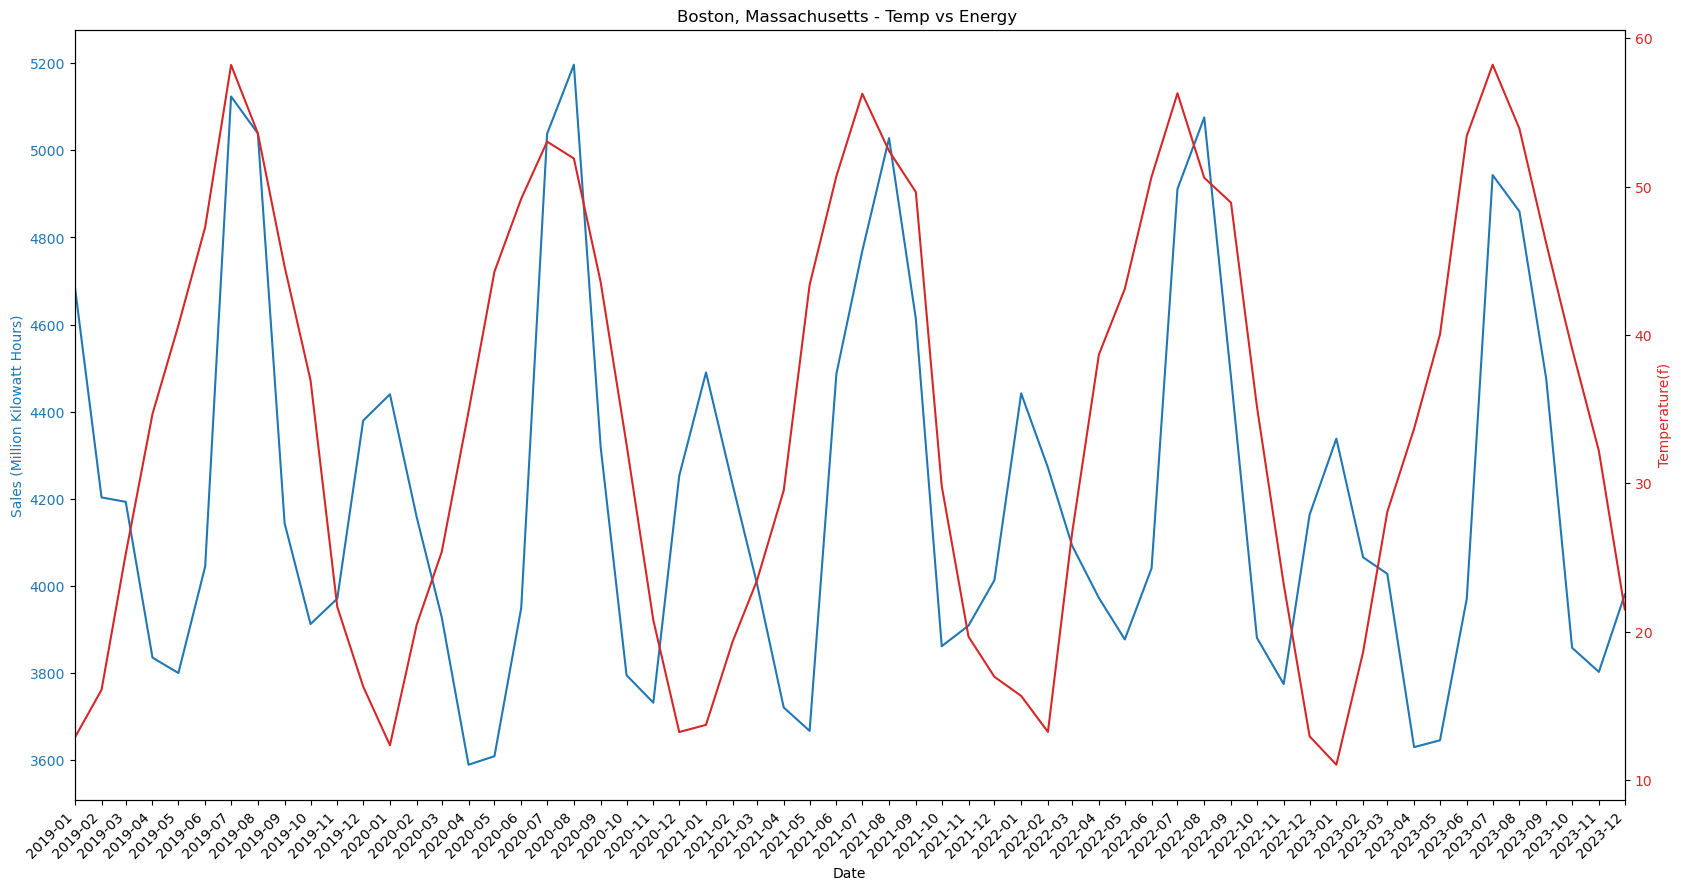

In [473]:
## TODO: ADD Plots Below

# Merge the DataFrames on the 'Date' column
merged_df = pd.merge(energy_df, monthly_df, left_on='Date', right_on='Date')
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%m/%Y', errors='coerce')

merged_df.head()

# Plotting
fig, ax1 = plt.subplots(figsize = (20,10))

# Plot Unit Price on the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales (Million Kilowatt Hours)', color='tab:blue')
ax1.plot(merged_df['Date'], merged_df['Sales'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for Temperature
ax2 = ax1.twinx()
ax2.set_ylabel('Temperature(f)', color='tab:red')
ax2.plot(merged_df['Date'], merged_df['Mean Temperature (f)'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Manually set the x-tick labels
ax1.set_xticks(merged_df['Date'][::1])  # Adjust the step to show more or fewer labels
ax1.set_xticklabels(merged_df['Date'][::1].dt.strftime('%Y-%m'))

# Rotate the x-axis labels
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Set x-axis limits to the range of your data
ax1.set_xlim([merged_df['Date'].min(), merged_df['Date'].max()])

plt.title(f'{first_result_city_name}, {first_result_state_name} - Temp vs Energy ')
plt.savefig(f'Output/{first_result_city_name}_temp_vs_sales.png')

plt.show()

# Export dataframe to a csv
merged_df.to_csv(f'Output/{first_result_city_name}_temp_vs_sales.csv', index=False)


18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing


        Date       Sales
0 2023-12-01  3980.59995
1 2023-11-01  3803.02665
2 2023-10-01  3858.39307
3 2023-09-01  4476.12707
4 2023-08-01  4859.66918
          ds           y
0 2023-12-01  3980.59995
1 2023-11-01  3803.02665
2 2023-10-01  3858.39307
3 2023-09-01  4476.12707
4 2023-08-01  4859.66918


c:\Users\HollidayDDS\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\HollidayDDS\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


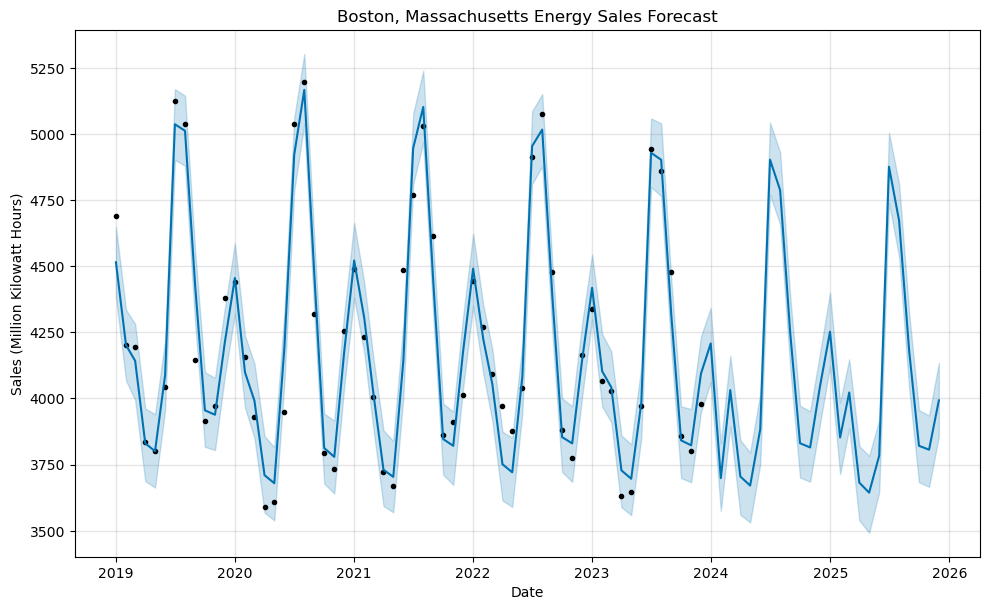

In [474]:
## Data Forecasting

# Predict energy costs based on prior data using prophet.
import prophet
from prophet import Prophet

# Create a new dataframe with the 'ds' and 'y' columns.
df_prophet = merged_df[['Date', 'Sales']]
print(df_prophet.head())

# Rename columns.
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Sales': 'y'})
print(df_prophet.head())

# Create a prophet model.
model = Prophet()
model.fit(df_prophet)

# Predict the future using the prophet model.
futurepredicitions = model.make_future_dataframe(periods=24, freq='ME')
forecast = model.predict(futurepredicitions)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Plot the forecast
fig = model.plot(forecast)
ax = fig.gca()
# Update axis labels
ax.set_xlabel('Date')
ax.set_ylabel('Sales (Million Kilowatt Hours)')
plt.title(f'{first_result_city_name}, {first_result_state_name} Energy Sales Forecast')
plt.savefig(f'Output/{first_result_city_name}_energy_sales_forecast.png')
plt.show()